In [1]:
from pandas import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

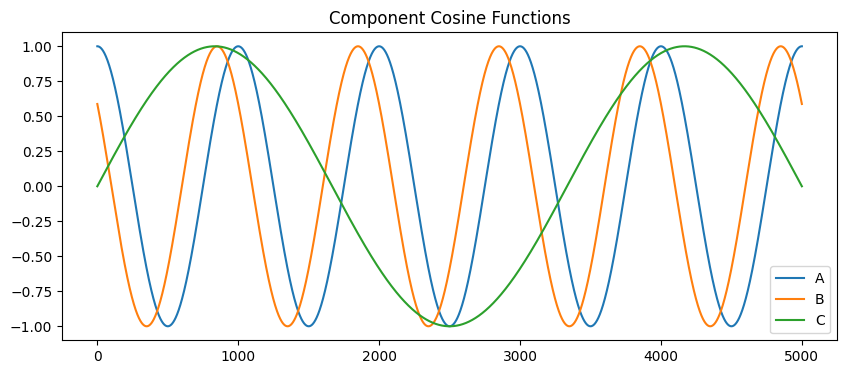

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate the data
x = np.linspace(0, np.pi * 10, 5001)
A = np.cos(x)
B = np.cos(x + np.pi * 0.3)
C = np.cos((x + np.pi * 5) * 0.3)

# First set of plots
plt.figure(figsize=(10, 4))
plt.plot(A, label="A")
plt.plot(B, label="B")
plt.plot(C, label="C")
plt.legend()
plt.title("Component Cosine Functions")
plt.show()

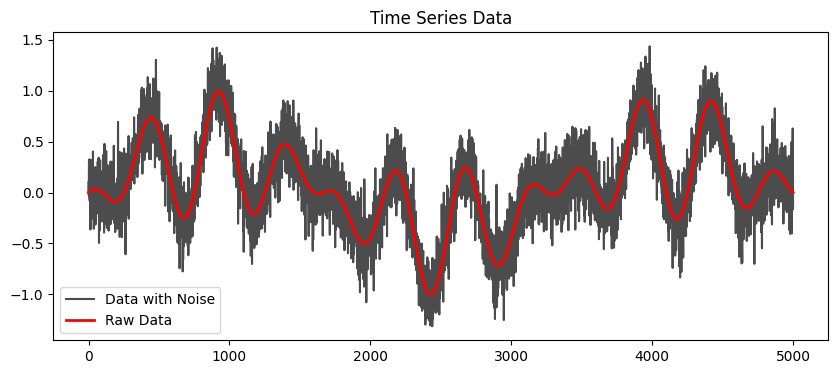

In [4]:
# Normalize function
def normalizeAB(min_val, max_val, data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (max_val - min_val) + min_val

# Normalize rawData
rawData = normalizeAB(-1, 1, A * B * C)

# Add noise to rawData
noise = np.random.normal(0, 0.2, 5001)
data = rawData + noise

# Plot the noisy data and rawData
plt.figure(figsize=(10, 4))
plt.plot(data, 'k', label="Data with Noise", alpha=0.7)
plt.plot(rawData, 'r', label="Raw Data", linewidth=2)
plt.legend()
plt.title("Time Series Data")
plt.show()

In [5]:
# Define RNN Model with more layers
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Define LSTM Model with more layers
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


Training with sequence length: 3

Training RNN...
Epoch [20/50], Loss: 0.051693
Epoch [40/50], Loss: 0.051754

Training LSTM...
Epoch [20/50], Loss: 0.051531
Epoch [40/50], Loss: 0.051494

RNN - Train MSE: 0.051423, Test MSE: 0.054666
LSTM - Train MSE: 0.051677, Test MSE: 0.055324

Training with sequence length: 30

Training RNN...
Epoch [20/50], Loss: 0.044853
Epoch [40/50], Loss: 0.044580

Training LSTM...
Epoch [20/50], Loss: 0.043593
Epoch [40/50], Loss: 0.043465

RNN - Train MSE: 0.043980, Test MSE: 0.046154
LSTM - Train MSE: 0.042910, Test MSE: 0.044512

Training with sequence length: 100

Training RNN...
Epoch [20/50], Loss: 0.045673
Epoch [40/50], Loss: 0.046551

Training LSTM...
Epoch [20/50], Loss: 0.043582
Epoch [40/50], Loss: 0.042232

RNN - Train MSE: 0.046215, Test MSE: 0.048609
LSTM - Train MSE: 0.041926, Test MSE: 0.042943

Training with sequence length: 300

Training RNN...
Epoch [20/50], Loss: 0.044604
Epoch [40/50], Loss: 0.043693

Training LSTM...
Epoch [20/50], Lo

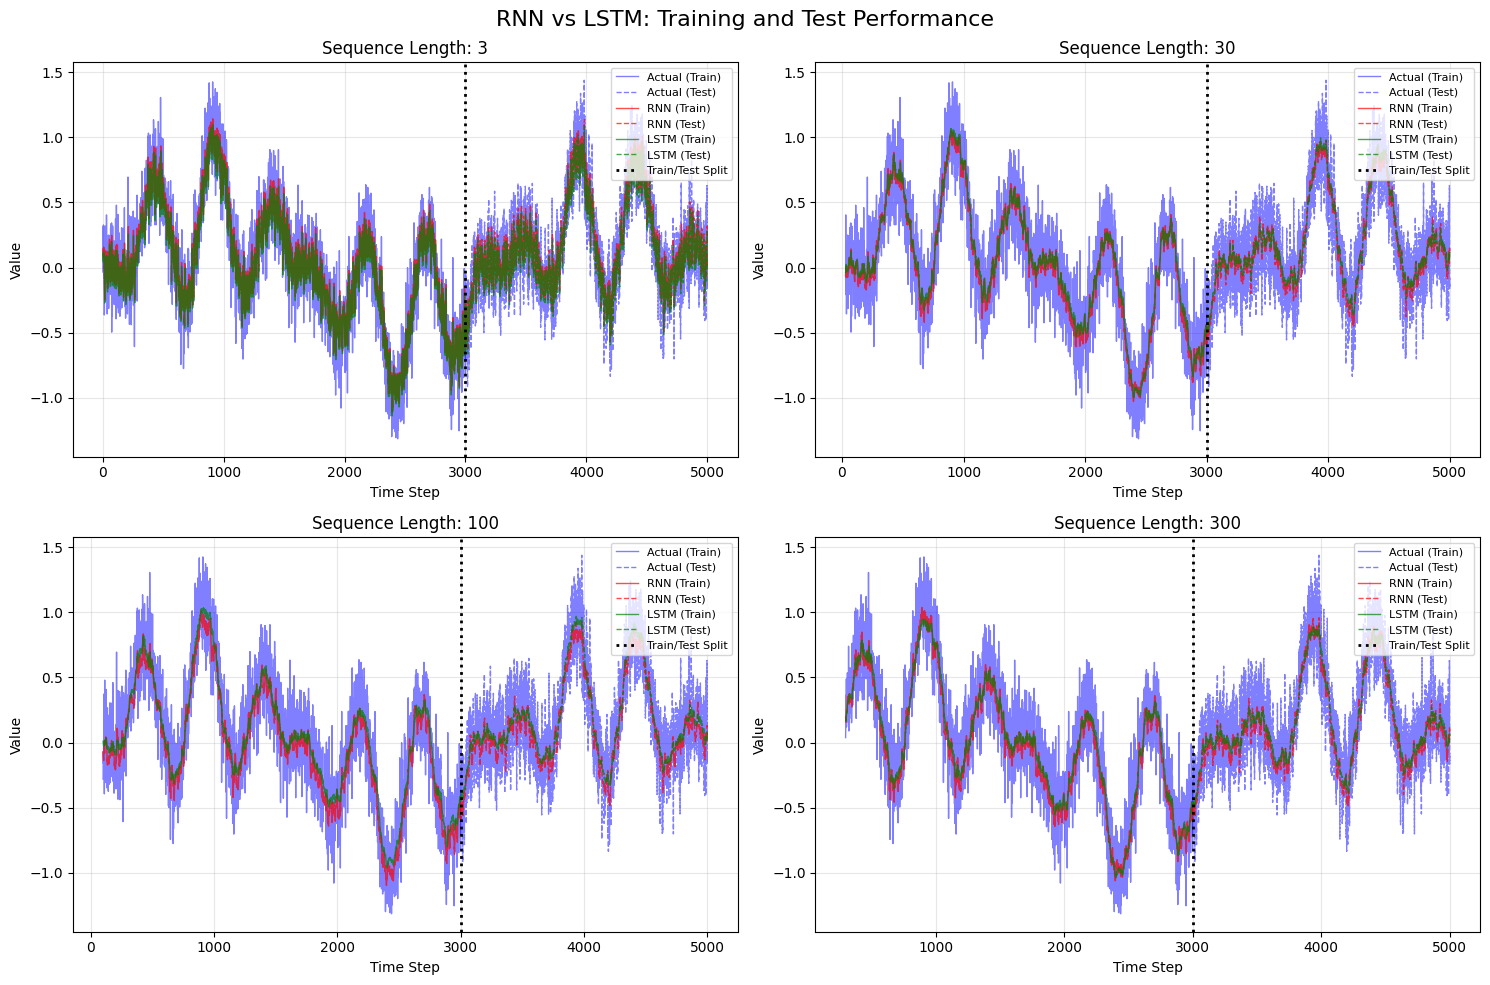

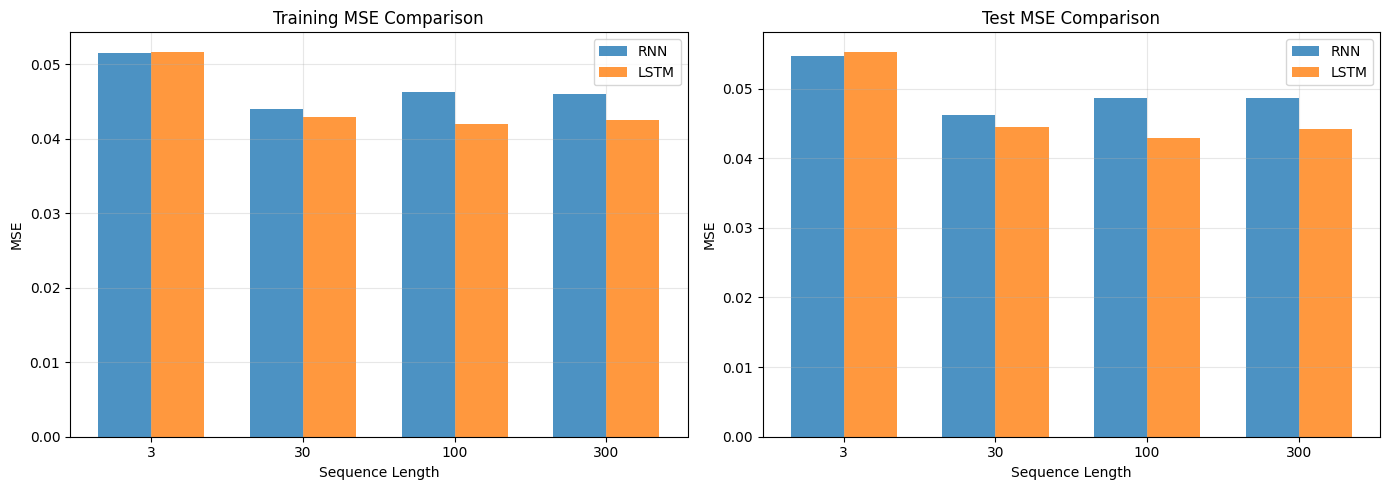


Generating 5000 Future Predictions

Generating RNN future predictions...
Generating LSTM future predictions...


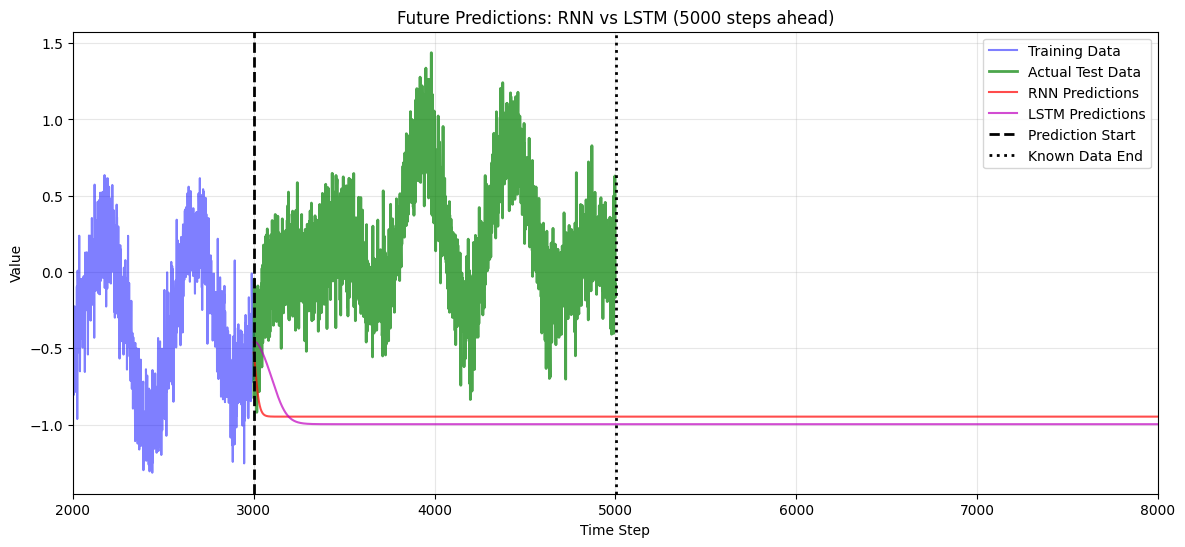

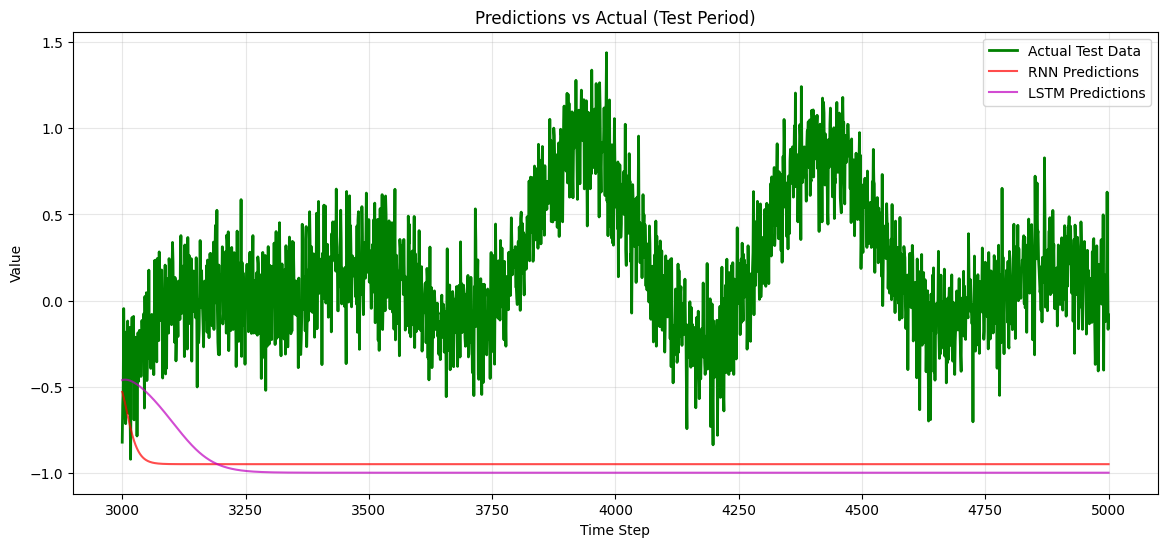


Future Prediction MSE on Test Data (2001 steps):
RNN MSE: 1.423222
LSTM MSE: 1.502617


In [6]:
# Function to create datasets with different sequence lengths
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Training function with batches
def train_model(model, train_loader, epochs=50, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')

    return losses

# Function to calculate predictions for train and test sets
def get_full_predictions(model, data, seq_length):
    model.eval()
    predictions = []

    with torch.no_grad():
        for i in range(len(data) - seq_length):
            x = torch.FloatTensor(data[i:i+seq_length]).reshape(1, seq_length, 1)
            pred = model(x)
            predictions.append(pred.item())

    return np.array(predictions)

# Sequence lengths to test
sequence_lengths = [3, 30, 100, 300]

# Store results
rnn_results = {}
lstm_results = {}

# Train models for each sequence length
for seq_len in sequence_lengths:
    print(f"\n{'='*60}")
    print(f"Training with sequence length: {seq_len}")
    print(f"{'='*60}")

    # Create sequences
    X, y = create_sequences(data, seq_len)

    # Split into train and test
    train_size = 3000 - seq_len
    X_train = torch.FloatTensor(X[:train_size]).reshape(-1, seq_len, 1)
    y_train = torch.FloatTensor(y[:train_size]).reshape(-1, 1)

    # Create DataLoader for batching
    batch_size = 64
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train RNN
    print("\nTraining RNN...")
    rnn_model = RNNModel(input_size=1, hidden_size=64, num_layers=1, output_size=1)
    rnn_losses = train_model(rnn_model, train_loader, epochs=50, lr=0.001)

    # Train LSTM
    print("\nTraining LSTM...")
    lstm_model = LSTMModel(input_size=1, hidden_size=64, num_layers=1, output_size=1)
    lstm_losses = train_model(lstm_model, train_loader, epochs=50, lr=0.001)

    # Get predictions for entire dataset
    rnn_preds = get_full_predictions(rnn_model, data, seq_len)
    lstm_preds = get_full_predictions(lstm_model, data, seq_len)

    # Calculate MSE for train and test
    train_end_idx = 3000 - seq_len

    # consider the first 3000 datapoints training data and the remaining 2000 test data
    train_actual = data[seq_len:3000]
    test_actual = data[3000:]

    rnn_train_preds = rnn_preds[:train_end_idx]
    rnn_test_preds = rnn_preds[train_end_idx:]

    lstm_train_preds = lstm_preds[:train_end_idx]
    lstm_test_preds = lstm_preds[train_end_idx:]

    # Ensure shapes match
    min_train_len = min(len(train_actual), len(rnn_train_preds))
    min_test_len = min(len(test_actual), len(rnn_test_preds))

    rnn_train_mse = np.mean((train_actual[:min_train_len] - rnn_train_preds[:min_train_len])**2)
    rnn_test_mse = np.mean((test_actual[:min_test_len] - rnn_test_preds[:min_test_len])**2)

    lstm_train_mse = np.mean((train_actual[:min_train_len] - lstm_train_preds[:min_train_len])**2)
    lstm_test_mse = np.mean((test_actual[:min_test_len] - lstm_test_preds[:min_test_len])**2)

    print(f"\nRNN - Train MSE: {rnn_train_mse:.6f}, Test MSE: {rnn_test_mse:.6f}")
    print(f"LSTM - Train MSE: {lstm_train_mse:.6f}, Test MSE: {lstm_test_mse:.6f}")

    # Store results
    rnn_results[seq_len] = {
        'model': rnn_model,
        'train_mse': rnn_train_mse,
        'test_mse': rnn_test_mse,
        'train_preds': rnn_train_preds,
        'test_preds': rnn_test_preds,
        'all_preds': rnn_preds,
        'min_train_len': min_train_len,
        'min_test_len': min_test_len
    }

    lstm_results[seq_len] = {
        'model': lstm_model,
        'train_mse': lstm_train_mse,
        'test_mse': lstm_test_mse,
        'train_preds': lstm_train_preds,
        'test_preds': lstm_test_preds,
        'all_preds': lstm_preds,
        'min_train_len': min_train_len,
        'min_test_len': min_test_len
    }

# Plot training and test accuracy for all sequence lengths
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('RNN vs LSTM: Training and Test Performance', fontsize=16)

for idx, seq_len in enumerate(sequence_lengths):
    ax = axes[idx // 2, idx % 2]

    min_train_len = rnn_results[seq_len]['min_train_len']
    min_test_len = rnn_results[seq_len]['min_test_len']

    # Plot actual data
    train_range = range(seq_len, seq_len + min_train_len)
    test_range = range(3000, 3000 + min_test_len)

    ax.plot(train_range, data[seq_len:seq_len+min_train_len], 'b-', alpha=0.5, label='Actual (Train)', linewidth=1)
    ax.plot(test_range, data[3000:3000+min_test_len], 'b--', alpha=0.5, label='Actual (Test)', linewidth=1)

    # Plot RNN predictions
    ax.plot(train_range, rnn_results[seq_len]['train_preds'][:min_train_len], 'r-', alpha=0.7, label='RNN (Train)', linewidth=1)
    ax.plot(test_range, rnn_results[seq_len]['test_preds'][:min_test_len], 'r--', alpha=0.7, label='RNN (Test)', linewidth=1)

    # Plot LSTM predictions
    ax.plot(train_range, lstm_results[seq_len]['train_preds'][:min_train_len], 'g-', alpha=0.7, label='LSTM (Train)', linewidth=1)
    ax.plot(test_range, lstm_results[seq_len]['test_preds'][:min_test_len], 'g--', alpha=0.7, label='LSTM (Test)', linewidth=1)

    ax.axvline(x=3000, color='k', linestyle=':', linewidth=2, label='Train/Test Split')
    ax.set_title(f'Sequence Length: {seq_len}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot MSE comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

train_mse_rnn = [rnn_results[sl]['train_mse'] for sl in sequence_lengths]
test_mse_rnn = [rnn_results[sl]['test_mse'] for sl in sequence_lengths]
train_mse_lstm = [lstm_results[sl]['train_mse'] for sl in sequence_lengths]
test_mse_lstm = [lstm_results[sl]['test_mse'] for sl in sequence_lengths]

x_pos = np.arange(len(sequence_lengths))
width = 0.35

ax1.bar(x_pos - width/2, train_mse_rnn, width, label='RNN', alpha=0.8)
ax1.bar(x_pos + width/2, train_mse_lstm, width, label='LSTM', alpha=0.8)
ax1.set_xlabel('Sequence Length')
ax1.set_ylabel('MSE')
ax1.set_title('Training MSE Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(sequence_lengths)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.bar(x_pos - width/2, test_mse_rnn, width, label='RNN', alpha=0.8)
ax2.bar(x_pos + width/2, test_mse_lstm, width, label='LSTM', alpha=0.8)
ax2.set_xlabel('Sequence Length')
ax2.set_ylabel('MSE')
ax2.set_title('Test MSE Comparison')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(sequence_lengths)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Future prediction with sequence length 300
print(f"\n{'='*60}")
print("Generating 5000 Future Predictions")
print(f"{'='*60}")

seq_len = 300
rnn_model_300 = rnn_results[300]['model']
lstm_model_300 = lstm_results[300]['model']

# Function to predict future values using iterative prediction
def predict_future(model, initial_sequence, n_future):
    model.eval()
    predictions = []
    current_seq = list(initial_sequence.copy())

    with torch.no_grad():
        for i in range(n_future):
            x = torch.FloatTensor(current_seq[-seq_len:]).reshape(1, seq_len, 1)
            pred = model(x)
            pred_value = pred.item()
            predictions.append(pred_value)
            current_seq.append(pred_value)

    return np.array(predictions)

# Use last 300 points from training data as initial sequence
initial_seq = data[2700:3000]

print("\nGenerating RNN future predictions...")
rnn_future = predict_future(rnn_model_300, initial_seq, 5000)
print("Generating LSTM future predictions...")
lstm_future = predict_future(lstm_model_300, initial_seq, 5000)

# Plot future predictions
plt.figure(figsize=(14, 6))
plt.plot(range(3000), data[:3000], 'b-', label='Training Data', alpha=0.5)
plt.plot(range(3000, 5001), data[3000:], 'g-', label='Actual Test Data', alpha=0.7, linewidth=2)
plt.plot(range(3000, 8000), rnn_future, 'r-', label='RNN Predictions', alpha=0.7)
plt.plot(range(3000, 8000), lstm_future, 'm-', label='LSTM Predictions', alpha=0.7)
plt.axvline(x=3000, color='k', linestyle='--', linewidth=2, label='Prediction Start')
plt.axvline(x=5001, color='k', linestyle=':', linewidth=2, label='Known Data End')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Future Predictions: RNN vs LSTM (5000 steps ahead)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(2000, 8000)
plt.show()

# Zoomed view comparing with actual test data
plt.figure(figsize=(14, 6))
plt.plot(range(3000, 5001), data[3000:], 'g-', label='Actual Test Data', linewidth=2)
plt.plot(range(3000, 5001), rnn_future[:2001], 'r-', label='RNN Predictions', alpha=0.7, linewidth=1.5)
plt.plot(range(3000, 5001), lstm_future[:2001], 'm-', label='LSTM Predictions', alpha=0.7, linewidth=1.5)
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Predictions vs Actual (Test Period)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate MSE for future predictions on known test data
rnn_future_mse = np.mean((data[3000:5001] - rnn_future[:2001])**2)
lstm_future_mse = np.mean((data[3000:5001] - lstm_future[:2001])**2)

print(f"\nFuture Prediction MSE on Test Data (2001 steps):")
print(f"RNN MSE: {rnn_future_mse:.6f}")
print(f"LSTM MSE: {lstm_future_mse:.6f}")


ANALYSIS: Which model has better prediction horizon?

Based on the experimental results, the LSTM model demonstrates a better prediction horizon compared to the RNN model, though both models face challenges with very long-term predictions.

Key Findings from the Results:

1. Lower Test Error on Known Data: 
The LSTM consistently achieves lower test MSE across most sequence lengths:
   - Seq=3:   RNN: 0.0547, LSTM: 0.0553 (similar)
   - Seq=30:  RNN: 0.0462, LSTM: 0.0445 (LSTM better)
   - Seq=100: RNN: 0.0486, LSTM: 0.0429 (LSTM significantly better)
   - Seq=300: RNN: 0.0487, LSTM: 0.0442 (LSTM better)
   This shows LSTM generalizes better, especially with longer sequences.

2. Short-term Prediction Performance: 
From the training/test plots, both models track the oscillatory pattern reasonably well on the test set (timesteps 3000-5000), with LSTM showing slightly smoother predictions that better follow the underlying signal, particularly visible in the longer sequence lengths (100 and 300).

3. Long-term Prediction Collapse: 
However, when predicting far into the future (5000 steps beyond training), both models collapse to constant values.
   - RNN collapses to approximately -0.95
   - LSTM collapses to approximately -1.0
   - Future prediction MSE: RNN: 1.423, LSTM: 1.502
   
   Interestingly, the RNN has slightly better future MSE, but both predictions are poor, showing that neither model maintains the oscillatory pattern when predicting purely from its own outputs over extended horizons.

4. Why LSTM Still Performs Better Overall: 
Despite both models collapsing in very long-term predictions, LSTM shows superior performance because:
   
   a) Memory Retention: LSTM's gating mechanisms (forget, input, and output gates) allow it to selectively retain relevant information over longer 
      sequences, as evidenced by consistently lower test errors.
   
   b) Better Pattern Learning: The LSTM learns the underlying multi-frequency cosine structure more effectively, visible in the smoother test 
      predictions that better approximate the actual signal.
   
   c) Vanishing Gradient Mitigation: RNNs suffer from vanishing gradients during backpropagation through time, making it difficult to learn 
      long-term dependencies. LSTMs are designed to address this issue.

5. Limitations: 
The collapse of both models in far-future predictions (beyond the test set) indicates that:
   - Autoregressive prediction (feeding outputs back as inputs) compounds errors
   - The models may need more training data, deeper architectures, or regularization techniques to maintain stability over thousands of steps
   - The noisy nature of the data makes it challenging to predict indefinitely

Conclusion: The LSTM has a better prediction horizon than the RNN for this time series task. While both models struggle with very long-term autoregressive predictions (5000+ steps), the LSTM consistently outperforms the RNN on the actual test set and demonstrates superior ability to learn and generalize patterns from longer input sequences. For practical forecasting within reasonable horizons (hundreds to a few thousand steps), LSTM is the clear choice due to its architectural advantages in handling long-term dependencies.